# Visualizing and Understanding Convolutional Neural Networks

This notebook contains the implementation of the paper `Visualizing and Understading Neural Networks Paper`

The dataset we used is a subset of `ImageNet 2012 ` dataset downloaded from Kaggle datasets. - https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000

In [1]:
# Import required libraries
import numpy as np
import torch 
from torch import nn
import torchvision
import pathlib 
import os
import matplotlib.pyplot as plt
import json
import random

from tqdm.auto import tqdm
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image
from helper_functions import engine

c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Making the data ready to go into our Model

### Setting up training and test directories and Transforms

In [3]:
# Setting up train and test dirs
train_dir = "datasets/imagenet-mini/train"
test_dir = "datasets/imagenet-mini/val"

# Setup transforms for the imagenet dataset
weights = torchvision.models.ResNet101_Weights.DEFAULT
transforms = weights.transforms()

print(f"Train directory path: {train_dir}")
print(f"Test directory path: {test_dir}")
print(F"Transforms: {transforms}")

Train directory path: datasets/imagenet-mini/train
Test directory path: datasets/imagenet-mini/val
Transforms: ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### Turning our data into datasets

In [4]:
train_dataset = ImageFolder(root=train_dir,
                            transform=transforms)

test_dataset = ImageFolder(root=test_dir,
                           transform=transforms)

class_names = train_dataset.classes

print(f"Number of samples in Training data: {len(train_dataset)}")
print(f"Number of samples in Test data: {len(test_dataset)} ")
print(f"Total number of classes: {len(class_names)}")

Number of samples in Training data: 34745
Number of samples in Test data: 3923 
Total number of classes: 1000


### Converting labels to human readable format

In [5]:
class_names_dict = {}
with open("datasets\imagenet-mini\class_names.txt") as f:
    for line in f:
        (k, v) = line.split(':')
        class_names_dict[int(k)] = v.split(",")[0]


class_names = []
for key, value in class_names_dict.items():
    class_names.append(value)
    
class_names[:5]

[' tench', ' goldfish', ' great white shark', ' tiger shark', ' hammerhead']

### Visualizing random samples of the data

Random image path: datasets\imagenet-mini\train\n04479046\n04479046_5635.JPEG 
Image dimensions (height x width): 500 x 375


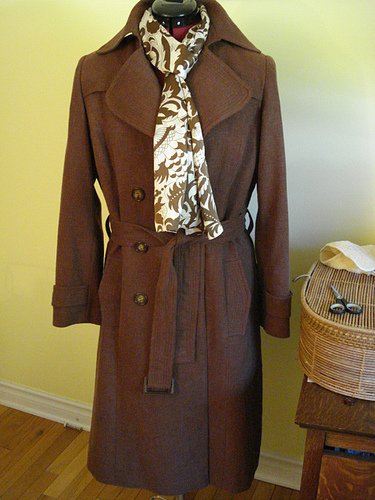

In [6]:
# Make a list of all images to randomly select an image
image_path_list = list(Path(train_dir).glob("*/*.jpeg"))

# Select a random image from the image path list
random_image_path = random.choice(image_path_list)

# Visualize the random image
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path} ")
print(f"Image dimensions (height x width): {img.height} x {img.width}")
img

In [7]:
# Testing our transforms 
torch_img = torchvision.transforms.ToTensor()(img)

print(f"Shape of the image before going through transforms: {torch_img.shape}")

Shape of the image before going through transforms: torch.Size([3, 500, 375])


### Converting our datasets into DataLoaders

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = 2

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x15d773a7fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x15d65e55000>)

In [9]:
# Check the shape of our input sample
image, label = next(iter(train_dataset))

print(f"Shape of the image: {image.shape}")
print(label)

Shape of the image: torch.Size([3, 224, 224])
0


## Modelling

The original architecture is taking so much time to run so let's use another model to visualize the Convolutional layers

In [10]:
model = torchvision.models.resnet101(weights=weights).to(device)

# freeze all the layers
for param in model.parameters():
    param.requires_grad = False


In [11]:
# Get the summary of the model
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 1000]                 --
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         (9,408)
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         (128)
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]           [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]           [1, 64, 56, 56]           (128)
│    │    └─ReLU (r

No need to train the model as the model is already pretrained

### Visualizing what each layer in the model learns

In [12]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
# print(conv_layers)

Total convolution layers: 100


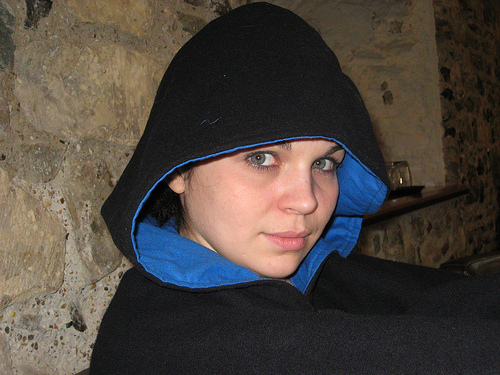

In [21]:
import cv2
# Make a list of all images to randomly select an image
image_path_list = list(Path(train_dir).glob("*/*.jpeg"))

# Select a random image from the image path list
random_image_path = random.choice(image_path_list)

# Visualize the random image
image = Image.open(random_image_path)
# Converting image to tensor
img = transforms(image).unsqueeze(0).to(device)
image

In [22]:
# Generate feature maps
outputs = []

for layer in conv_layers:
    img = layer(img)
    outputs.append(img)

for feature_map in outputs:
    print(feature_map.shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 

In [23]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


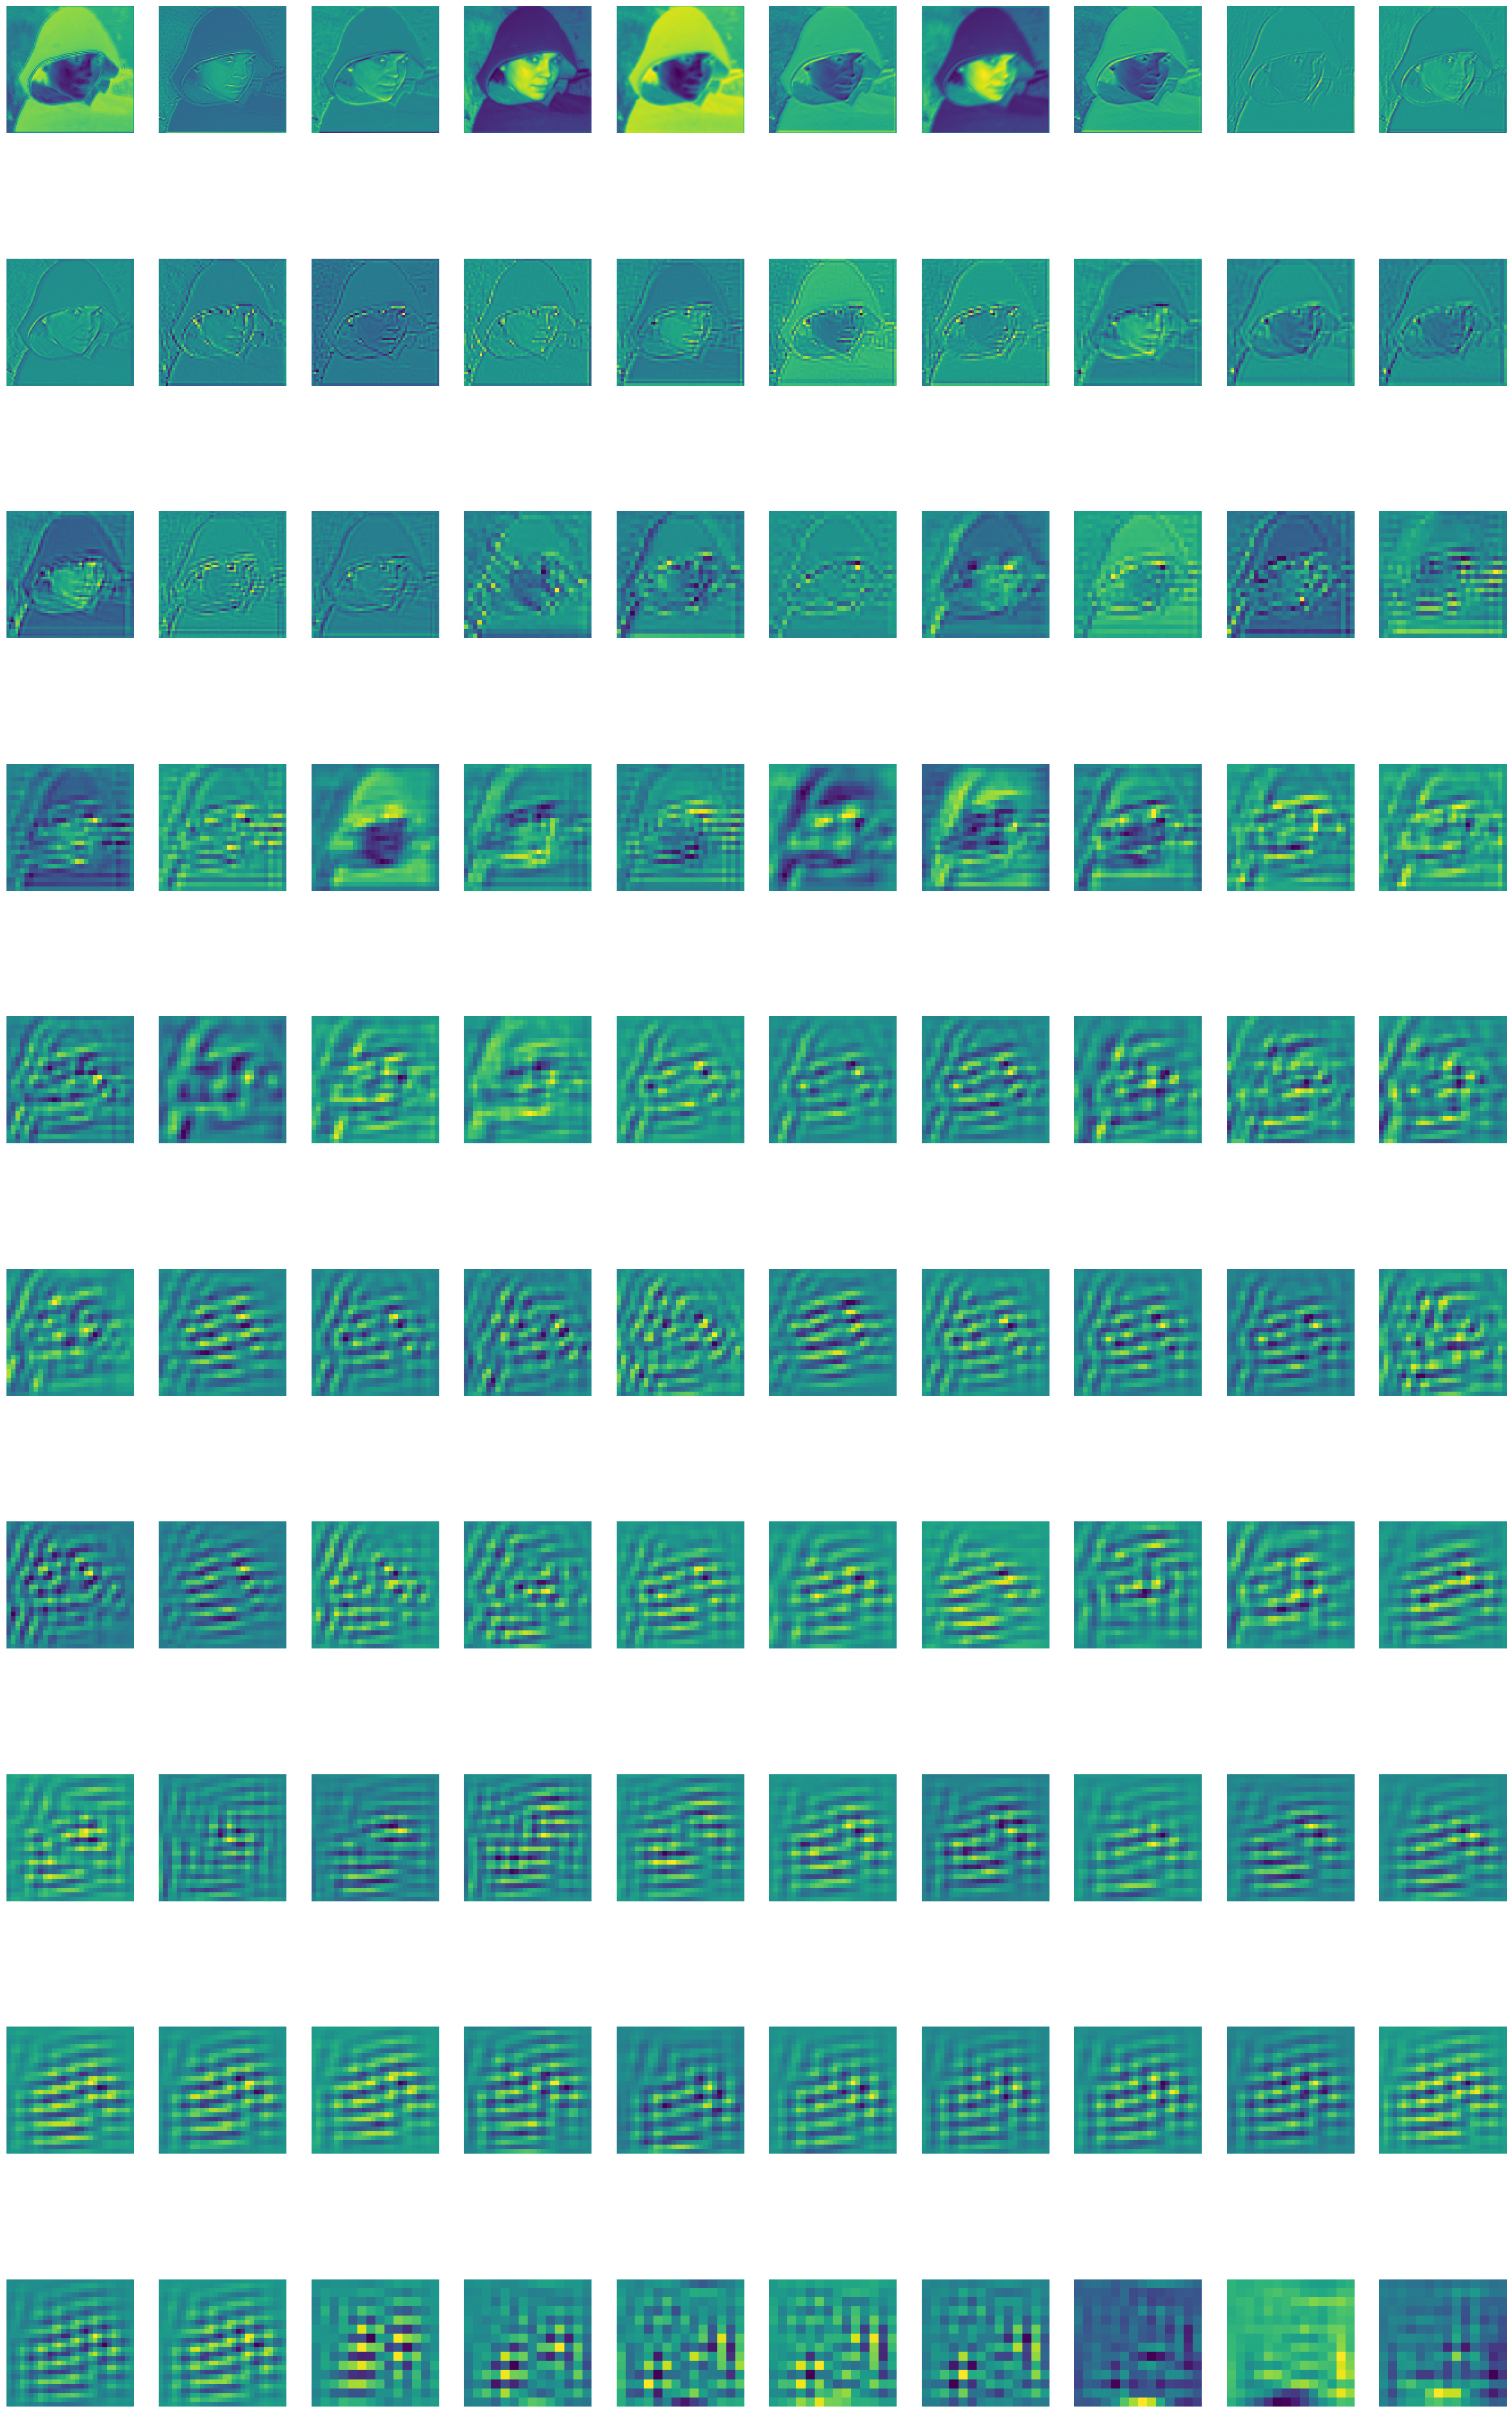

In [24]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(10, 10, i+1)
    plt.imshow(processed[i])
    a.axis("off")
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')